# Learning Uncertainty Sets

In [99]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
warnings.filterwarnings("ignore")

### Example 4: Portfolio management


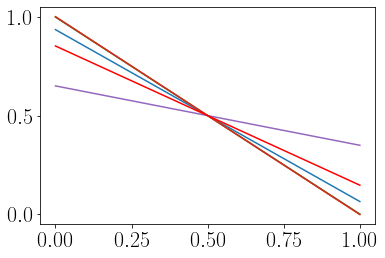

In [100]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + i*0.05*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

def loss(t,x,p,alpha, data,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums1 = torch.mean(-data@x)
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return t + 0.2*torch.norm(x-p,1) + torch.tensor(l)*(sums - torch.tensor(target)), sums1 + 0.2*torch.norm(x-p,1), totsum/Nsample, sums.detach().numpy()

n = 2
N = 300
seed = 15
np.random.seed(seed)
data = data_modes(600,n,[1],seed = seed)
dist = (np.array([25,10,60,50,40,30,30,20,20,15,10,10,10,10,10,10])/100)[:n]
#dist = np.ones(n)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = np.reshape(np.random.dirichlet(dist,1),(n,))

for i in range(num_scenarios):
  plt.plot(scenarios[i][0])

x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t)

constraints = [-data@x <= t,cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
plt.plot(x.value, color = "red")

In [129]:
def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.4],[-0.3,0.1]])
    mu = np.array((0.9,0.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train
data = gen_demand_intro(600, seed=5)

In [130]:
# data = data_modes(600,n,[1,2,5],seed = 15)
# data = np.exp(data)
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

prob = lropt.RobustProblem(objective, constraints)
target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init = np.eye(n)
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.00001, step=300, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_lam = 1, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.01)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

# result3 = prob.train(eps = True, lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_lam = 10,  target_cvar = target, init_alpha =0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
# df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 10, 100), init_A = init, init_b = init_bval, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01, 10, 100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

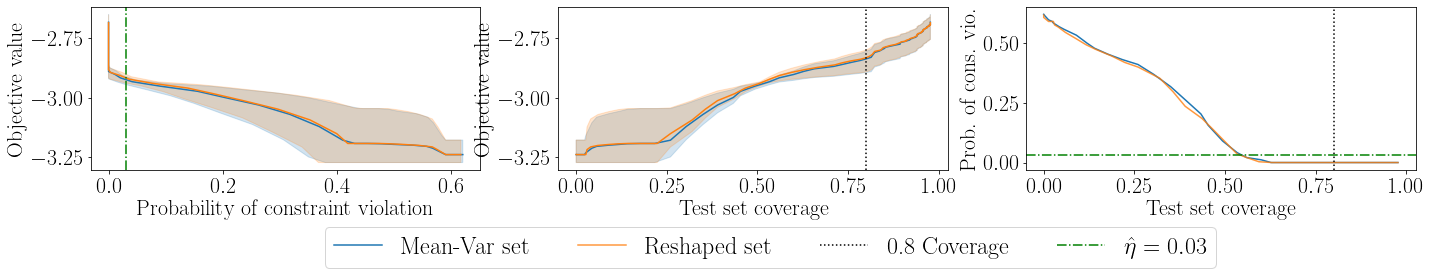

In [131]:
plot_coverage_all(dfgrid,dfgrid2,None, "Portlinear2",ind_1=(0,400),ind_2=(0,400), logscale = False, zoom = False,legend = True)

In [132]:
eps_list = np.linspace(0.01, 10, 100)
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())
st_eps = np.linspace(0.01, 10, 100)[inds_standard[0]]
re_eps = np.linspace(0.01, 10, 100)[inds_reshaped[0]]
st_eps, re_eps

(2.2299999999999995, 2.2299999999999995)

In [133]:
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(num_scenarios):
        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_standard[ind]])*init, b = (1/eps_list[inds_standard[ind]])*init_bval))
        # Formulate the Robust Problem
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[0][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x.value

        t_base[ind][scene] = t.value

        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_reshaped[ind]])*A_fin, b = (1/eps_list[inds_reshaped[ind]])*b_fin))
        # Formulate the Robust Problem
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[0][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x.value

        t_learned[ind][scene] = t.value
        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[1.00788263e+00, 8.40678233e-03],
        [5.54894980e-04, 1.00048431e+00]]),
 array([-3.13278499, -2.33721103]),
 array([[1., 0.],
        [0., 1.]]),
 array([-3.1364797 , -2.33746108]))

In [134]:
K =1
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(num_scenarios):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
            
            for scene in range(num_scenarios):
                g_level_learned[ind][scene][i,j] = -x_opt_learned[ind][scene]@u_vec - t_learned[ind][scene]
                g_level_base[ind][scene][i,j] = -x_opt_base[ind][scene]@u_vec - t_base[ind][scene]

In [135]:

def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, title, standard = True):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]

    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        for scene in range(num_scenarios):
            axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(train[:,0],train[:,1], color = "white",edgecolor = "black")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(1):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')

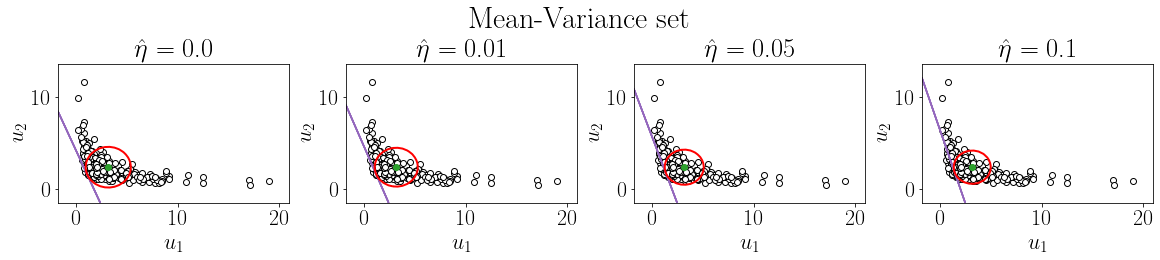

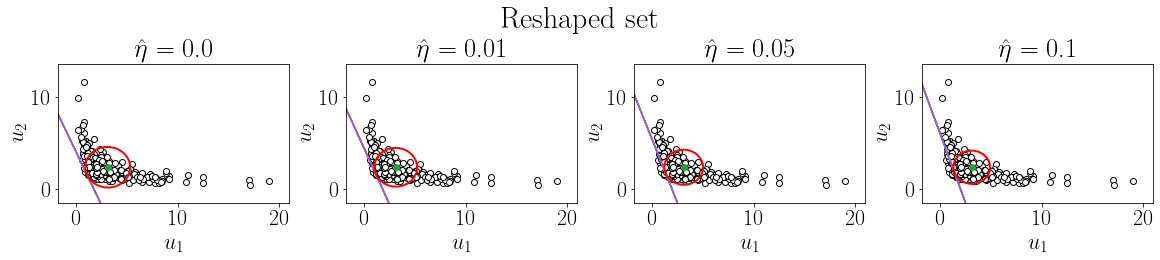

In [136]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,num_scenarios,train, "port_intro",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,num_scenarios,train, "port_intro",standard = False)

In [73]:
mro(train, test, K = 300, rho = 0.698)

(array([0.05666667, 0.05666667, 0.05333333, 0.02333333, 0.        ]),
 array([0.07333333, 0.07      , 0.07333333, 0.01666667, 0.        ]),
 array([-0.26963487, -0.27016231, -0.26076199, -0.05902049, -0.15850891]),
 array([0.01354783, 0.01255842, 0.01396725, 0.013687  , 0.012508  ]))

In [72]:
np.mean([0.05666667, 0.05666667, 0.05333333, 0.02333333, 0.        ])

0.038

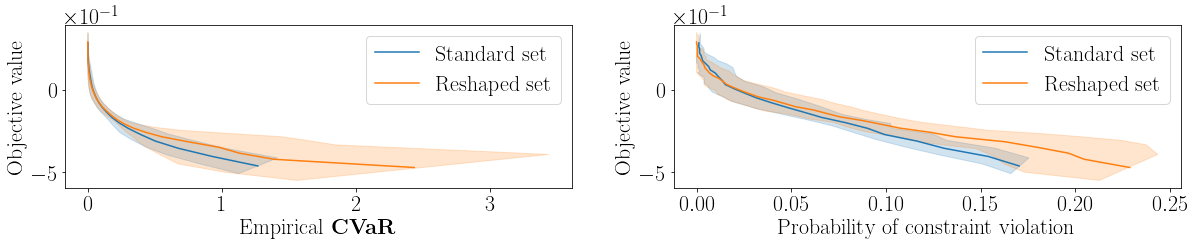

In [5]:
plot_tradeoff(dfgrid,dfgrid2,"Port",ind_1 = (10,100), ind_2 = (0,100))

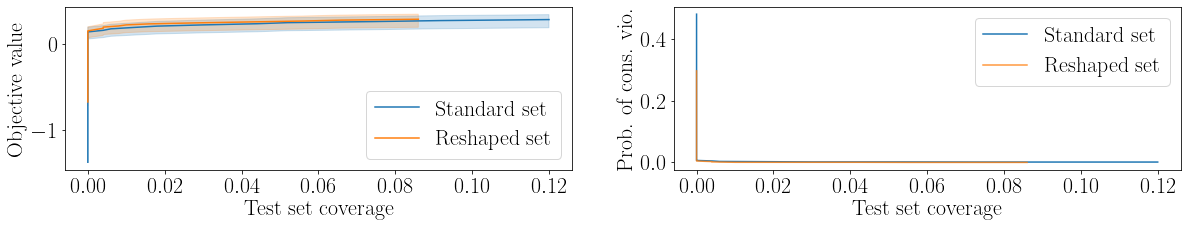

In [7]:
plot_coverage(dfgrid,dfgrid2,"port",ind_1=(0,100),ind_2=(0,100))

In [85]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    # ax.scatter(0.03,y = np.mean([-0.26913068, -0.26968575, -0.26027287, -0.05857202, -0.15843752]), color = "red")
    # ax.axhline(y = np.mean([-0.26913068, -0.26968575, -0.26027287, -0.05857202, -0.15843752]), color = "red", linestyle = "-.",label = r"$MRO = 0.03$")
    
    ax.set_ylabel("Objective value")
    # ax.set_yticks(ticks = [-2e1,0,2e1])
    # ax.set_yticks(ticks = [-1,0,1])
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    # ax1.set_yticks(ticks = [-1,0,1])

    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if zoom:
        axins = zoomed_inset_axes(ax2, 6, loc="upper center")
        axins.set_xlim(-0.005, 0.1)
        axins.set_ylim(-0.001,0.035)
        axins.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue")
        axins.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange",alpha = 0.8)
        axins.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
        axins.set_xticks(ticks=[])
        axins.set_yticks(ticks=[])
        mark_inset(ax2, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

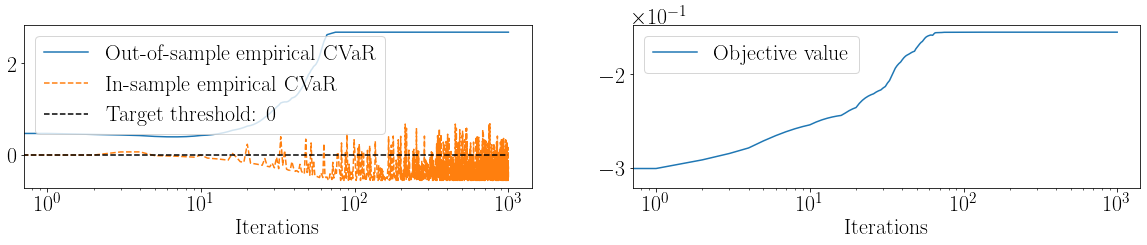

In [8]:
plot_iters(df1,"Port",logscale = 1,steps = 3000)

In [6]:
def plot_coverage(df_standard,df_reshape,title,ind_1 = (0,100), ind_2 = (0,100)):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Reshaped set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set", alpha = 0.8)
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax2.legend()
    # plt.savefig(title+"_curve.pdf",bbox_inches='tight')
    plt.show()

In [34]:
def eval(t,x,p, data):
    t = torch.tensor(t)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)
    sums = 0
    totsum = torch.sum(torch.where(torch.maximum(-data@x - t, torch.tensor(0.,requires_grad = True))>= 0.0001,torch.tensor(1.), torch.tensor(0.)))
    Nsample = data.shape[0]
    return totsum/Nsample

def make_table(result_A, result_b, df,test,train,value = 0., eps = 1,cvar_train = 0, cvar_test = 0):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
            r_eps = 1
        else:
            r_eps = df['Eps'][np.absolute(np.mean(np.vstack(df['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(n,
                                        uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                        rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))
        # formulate cvxpy variable
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        trial1[scene,0] = newprob.objective.value
        trial1[scene,1] = eval(t.value, x.value, p.value, test).item()
        trial1[scene,2] = eval(t.value, x.value, p.value, train).item()
        trial1[scene,3] = cvar_train
        trial1[scene,4] = cvar_test
        trial1[scene,5] = newprob.solver_stats.solve_time
    return trial1

In [60]:
Ar_saved = np.zeros((100,n,n))
br_saved = np.zeros((100,n))
As_saved = np.zeros((100,n,n))
bs_saved = np.zeros((100,n))
reshaped_table = np.zeros((1,24))
standard_table = np.zeros((1,24))
for experiment in range(100):
    data = data_modes(1000,n,[1,2,3],seed = experiment)
    
    # Formulate uncertainty set
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x = cp.Variable(n)
    t = cp.Variable()
    p = cp.Parameter(n)
    p.value = scenarios[0][0]
    # p1.value = scenarios[0][1]
    objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))

    constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

    prob = lropt.RobustProblem(objective, constraints)
    target = -0.01
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    result1 = prob.train(lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 1)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    result3 = prob.train(eps = True, lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    df_r2 = result3.df
    As_saved[experiment,:] = result3.A
    bs_saved[experiment,:] = result3.b

    # Grid search epsilon
    result4 = prob.grid(epslst = np.linspace(0.01, 3, 60), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(0.01, 3, 60), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.048, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0., eps = 1, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.01, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t3 = make_table(A_fin, b_fin, dfgrid2,test,train,0.03, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t = np.hstack((r_t, r_t1, r_t2, r_t3))
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(result3.A,result3.b, dfgrid,test,train, 0.048, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t1 = make_table(result3.A,result3.b, dfgrid,test,train, 0., eps = 1,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t2 = make_table(result3.A,result3.b, dfgrid,test,train, 0.01, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t3 = make_table(result3.A,result3.b, dfgrid,test,train, 0.03, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t = np.hstack((s_t, s_t1, s_t2, s_t3))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table_2.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table_2.csv")
    np.save("Ar_saved.npy", Ar_saved)
    np.save("As_saved.npy", As_saved)
    np.save("br_saved.npy", br_saved)
    np.save("bs_saved.npy", bs_saved)
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

In [47]:
print("test_vio_target: ", np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1)),"\n""train_vio_target: ", np.mean(np.mean(reshaped_table[:,20].reshape(-1, 5), axis=1)),"\n""test_obj_target: ", np.mean(np.mean(reshaped_table[:,18].reshape(-1, 5), axis=1)),"\n""test_vio: ", np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1)),"\n""train_vio: ", np.mean(np.mean(reshaped_table[:,8].reshape(-1, 5), axis=1)),"\n""test_obj: ", np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1)),"\n""test_cvar: ", np.mean(np.mean(reshaped_table[:,4].reshape(-1, 5), axis=1)),"\n""train_cvar: ",np.mean(np.mean(reshaped_table[:,3].reshape(-1, 5), axis=1)))

test_vio_target:  0.032320000089704946 
train_vio_target:  0.02984800047054882 
test_obj_target:  -0.19240147635945815 
test_vio:  0.016500000087078623 
train_vio:  0.012968000161461489 
test_obj:  -0.133561500314037 
test_cvar:  -0.0018806079707282674 
train_cvar:  -0.01053792247177647


In [19]:
np.mean(np.mean(reshaped_table[:,5].reshape(-1, 5), axis=1)), np.mean(np.mean(reshaped_table[:,23].reshape(-1, 5), axis=1))

(0.000612351928, 0.000590489252)

In [80]:
table = np.zeros((4,6))
table[0,0] =  np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1))
table[1,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1))
table[2,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,0] =  np.mean(np.mean(reshaped_table[:,11].reshape(-1, 5), axis=1))

table[0,1] =  np.mean(np.mean(reshaped_table[:,18].reshape(-1, 5), axis=1))
table[1,1] =  np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1))
table[2,1] =  np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1) >= 0.05)
table[3,1] =  np.mean(np.mean(reshaped_table[:,23].reshape(-1, 5), axis=1))

table[0,2] =  np.mean(np.mean(standard_table[:,6].reshape(-1, 5), axis=1))
table[1,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1))
table[2,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,2] =  np.mean(np.mean(standard_table[:,11].reshape(-1, 5), axis=1))

table[0,3] =  np.mean(np.mean(standard_table[:,18].reshape(-1, 5), axis=1))
table[1,3] =  np.mean(np.mean(standard_table[:,19].reshape(-1, 5), axis=1))
table[2,3] =  np.mean(np.mean(standard_table[:,19].reshape(-1, 5), axis=1) >= 0.05)
table[3,3] =  np.mean(np.mean(standard_table[:,23].reshape(-1, 5), axis=1))

table[0,4] =  np.mean(totalobjs,axis = 0)[11]
table[1,4] =  np.mean(totalvios, axis = 0)[11]
table[2,4] =  np.mean(np.mean(totalvios[:,11].reshape(-1, 5), axis=1) >= 0.05)
table[3,4] =  np.mean(totaltime, axis = 0)[11]

table[0,5] =  np.mean(sg_vals[:,1])
table[1,5] =  np.mean(sg_vals[:,0])
table[2,5] =  np.mean(sg_vals[:,0] >= 0.05)
table[3,5] =  np.mean(sg_vals[:,2])
pd.DataFrame(table).to_csv("table_vals.csv")


In [48]:
print("test_vio_target: ", np.mean(np.mean(standard_table[:,19].reshape(-1, 5), axis=1)),"\n""train_vio_target: ", np.mean(np.mean(standard_table[:,20].reshape(-1, 5), axis=1)),"\n""test_obj_target: ", np.mean(np.mean(standard_table[:,18].reshape(-1, 5), axis=1)),"\n""test_vio: ", np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1)),"\n""train_vio: ", np.mean(np.mean(standard_table[:,8].reshape(-1, 5), axis=1)),"\n""test_obj: ", np.mean(np.mean(standard_table[:,6].reshape(-1, 5), axis=1)),"\n""test_cvar: ", np.mean(np.mean(standard_table[:,4].reshape(-1, 5), axis=1)),"\n""train_cvar: ",np.mean(np.mean(standard_table[:,3].reshape(-1, 5), axis=1)))

test_vio_target:  0.028360000094398815 
train_vio_target:  0.03036800028011198 
test_obj_target:  -0.18076778619922051 
test_vio:  0.009460000155493581 
train_vio:  0.008612000132910864 
test_obj:  -0.10265505128871831 
test_cvar:  -0.007744786794471372 
train_cvar:  -0.010047478322100154


In [56]:
print(np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(sg_vals[:,0] >= 0.05))
print(np.mean(totalvios[:,11] >= 0.05))
print("reshaped = ", np.mean(reshaped_table[:,19]), np.mean(reshaped_table[:,18]),np.mean(reshaped_table[:,23]))
print("standard = ", np.mean(standard_table[:,19]), np.mean(standard_table[:,18]),np.mean(standard_table[:,23]))
print("DRO = ", np.mean(totalvios, axis = 0)[11] , np.mean(totalobjs,axis = 0)[11], np.mean(totaltime, axis = 0)[11])
print("SG = ", np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]),np.mean(sg_vals[:,2]))

0.0
0.03
0.0
0.02
reshaped =  0.032320000089704946 -0.19240147635945815 0.0005904892519999999
standard =  0.028360000094398815 -0.18076778619922051 0.0005962162660000001
DRO =  0.030260000247508287 -0.17868645188190904 0.066244756972
SG =  0.01874000005889684 -0.1174466837627108 0.003907776084


In [51]:
def mro(train,test, K = 500, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(n,
                                        uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
        # formulate cvxpy variable
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()

        objs[scene] = torch.mean(-torch.tensor(train)@torch.tensor(x.value))+ 0.2*torch.norm(torch.tensor(x.value)-torch.tensor(p.value),1)
        vios_1[scene] = eval(t.value, x.value, p.value, train).item()
        vios[scene] = eval(t.value, x.value, p.value, test).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios,vios_1, objs, time

In [37]:
totalvios = np.zeros((num_scenarios*100,20))
totalvios_train = np.zeros((num_scenarios*100,20))
totalobjs = np.zeros((num_scenarios*100,20))
totaltime = np.zeros((num_scenarios*100,20))
epsrange = np.linspace(0.1, 5, 20)
for experiment in range(100):
    print(experiment)
    data = data_modes(1000,n,[1,2,3],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 500, rho = eps)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios2.npy", totalvios)
        np.save("totalvios_train2.npy", totalvios_train)
        np.save("totalobjs2.npy", totalobjs)
        np.save("totaltime2.npy", totaltime)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


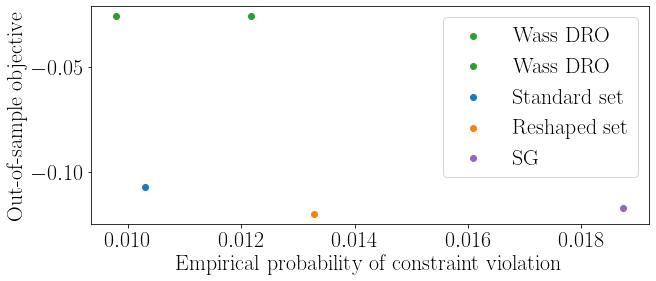

In [108]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totalvios_train, axis = 0)[13] , np.mean(totalobjs,axis = 0)[13], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(totalvios, axis = 0)[13] , np.mean(totalobjs,axis = 0)[13], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,13]), np.mean(standard_table[:,12]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,13]), np.mean(reshaped_table[:,12]),label = "Reshaped set", color = "tab:orange")
plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

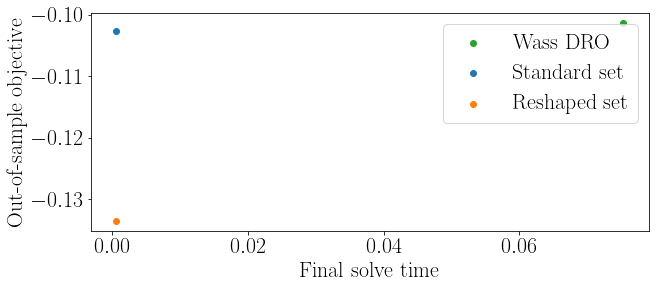

In [100]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totaltime, axis = 0)[12] , np.mean(totalobjs,axis = 0)[12], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,5]), np.mean(standard_table[:,6]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,5]), np.mean(reshaped_table[:,6]),label = "Reshaped set", color = "tab:orange")
# plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Final solve time")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

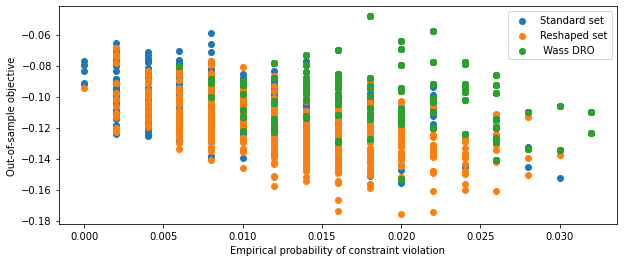

In [35]:
plt.figure(figsize = (10,4))
plt.scatter(standard_table[:,13], standard_table[:,12],label = "Standard set", color = "tab:blue")
plt.scatter(reshaped_table[:,13], reshaped_table[:,12],label = "Reshaped set", color = "tab:orange")
# plt.scatter(sg_vals[:,0], sg_vals[:,1],label = "SG", color = "tab:purple")
plt.scatter(totalvios[:,12] ,totalobjs[:,12], color = "tab:green", label = " Wass DRO")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [60]:
def sg(train,test):
    vios = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        # formulate cvxpy variable
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[0][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))
        constraints = [cp.sum(x)==1, x >= 0]
        for u in train:
            constraints += [-x@u <= t]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        objs[scene] = prob.objective.value
        vios[scene] = eval(t.value, x.value, p.value, test).item()
        time[scene] = prob.solver_stats.solve_time
    return vios, objs, time

In [61]:
sg_vals = np.zeros((num_scenarios*100,3))
for experiment in range(100):
    print(experiment)
    data = data_modes(1000,n,[1,2,3],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    vios, objs, time = sg(train,test)
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),0] = vios 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),1] = objs 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),2] = time
    np.save("sg_vals.npy", sg_vals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [4]:
standard_table = pd.read_csv("standard_table_2.csv").iloc[:,1:].values
reshaped_table = pd.read_csv("reshaped_table_2.csv").iloc[:,1:].values
totalvios = np.load("totalvios2.npy")
totalvios_train = np.load("totalvios_train2.npy")
totalobjs = np.load("totalobjs2.npy")
totaltime = np.load("totaltime2.npy")
sg_vals = np.load("sg_vals.npy")